# Basic Data Augmentation Method Applied to Time Series

This Notebook is taken from [this blog page](https://maddevs.io/writeups/basic-data-augmentation-method-applied-to-time-series/)

In [2]:
# Importing libraries

import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

## 0. Basic Definitions

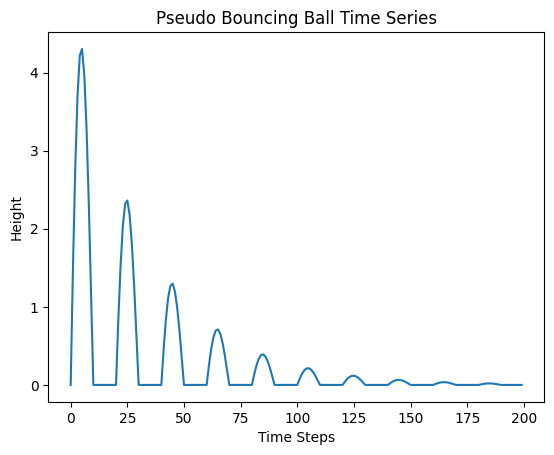

In [3]:
"""
Generating dataset
"""

def bouncing_ball_series(time_steps, initial_height, damping_factor, bounce_frequency):
    """
    Generates a time series that simulates the bounces of a bouncing ball.

    :param time_steps: Number of time steps (data points).
    :param initial_height: Initial bounce height.
    :param damping_factor: Height attenuation coefficient.
    :param bounce_frequency: Bounce frequency (number of bounces per time).
    :return: NumPy array representing the time series.
    """
    # Generate a time array
    time = np.arange(0, time_steps)

    # Function that simulates strikes (sine trimmed to zero and positive values)
    bounces = np.clip(np.sin(bounce_frequency * np.pi * time), 0, None)

    # Exponential decay over time
    damping = np.exp(-damping_factor * time)

    # Series of bounces taking into account attenuation
    series = initial_height * bounces * damping

    return series

# Parameters for generating time series
time_steps = 200          # Number of data points
initial_height = 5.0       # Initial height
damping_factor = 0.03      # Attenuation coefficient
bounce_frequency = 0.1     # Bounce frequency

# Generation of time series
time_series_data = bouncing_ball_series(time_steps, initial_height, damping_factor, bounce_frequency)

# Generation of time series
plt.plot(time_series_data)
plt.title('Pseudo Bouncing Ball Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Height')
plt.show()

## 1. Jittering / Gaussian noise

In [4]:
def add_gaussian_noise(time_series, mean=0.0, stddev=1.0):
    """
    Adds Gaussian noise to a time series.

     Options:
     time_series (array-like): A time series to which noise is added.
     mean (float): The average value of the noise. Default is 0.0.
     stddev (float): Standard deviation of noise. Default is 1.0.

     Returns:
     noisy_series (np.array): Time series with added noise.
     """
     # Gaussian noise generation
    noise = np.random.normal(mean, stddev, len(time_series))

    # Adding noise to the original time series
    noisy_series = time_series + noise

    return noisy_series

augmented_time_series_data = add_gaussian_noise(time_series_data, mean=0.0, stddev=0.05)

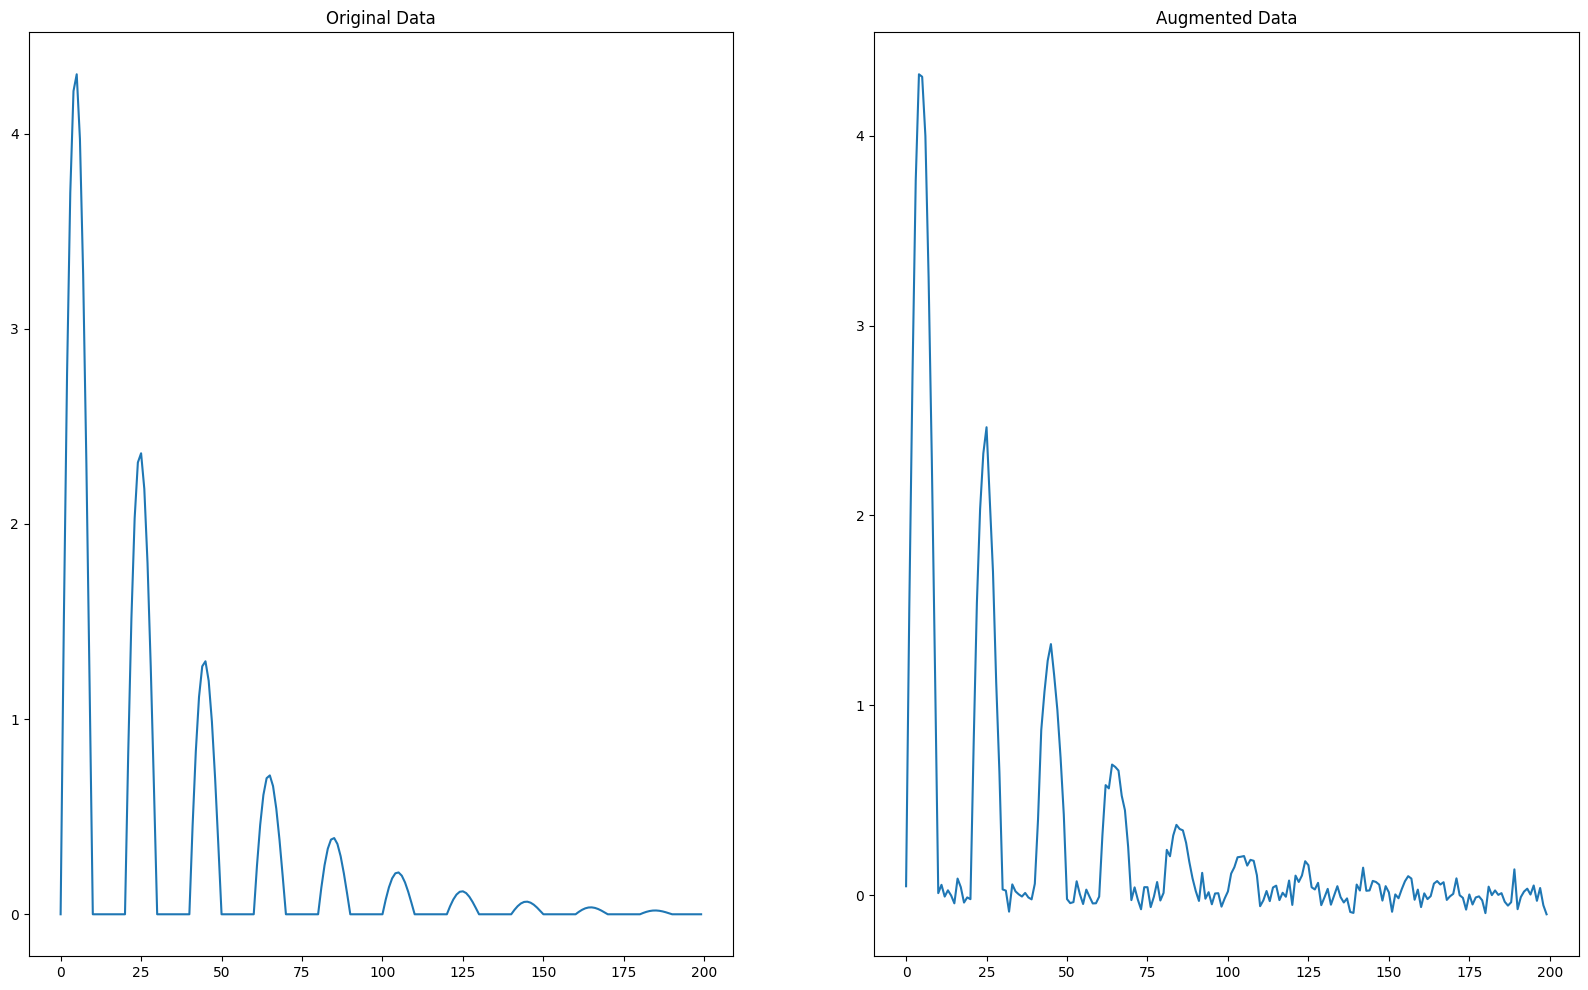

In [6]:
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(time_series_data)

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(augmented_time_series_data)

## 2. Time slicing window

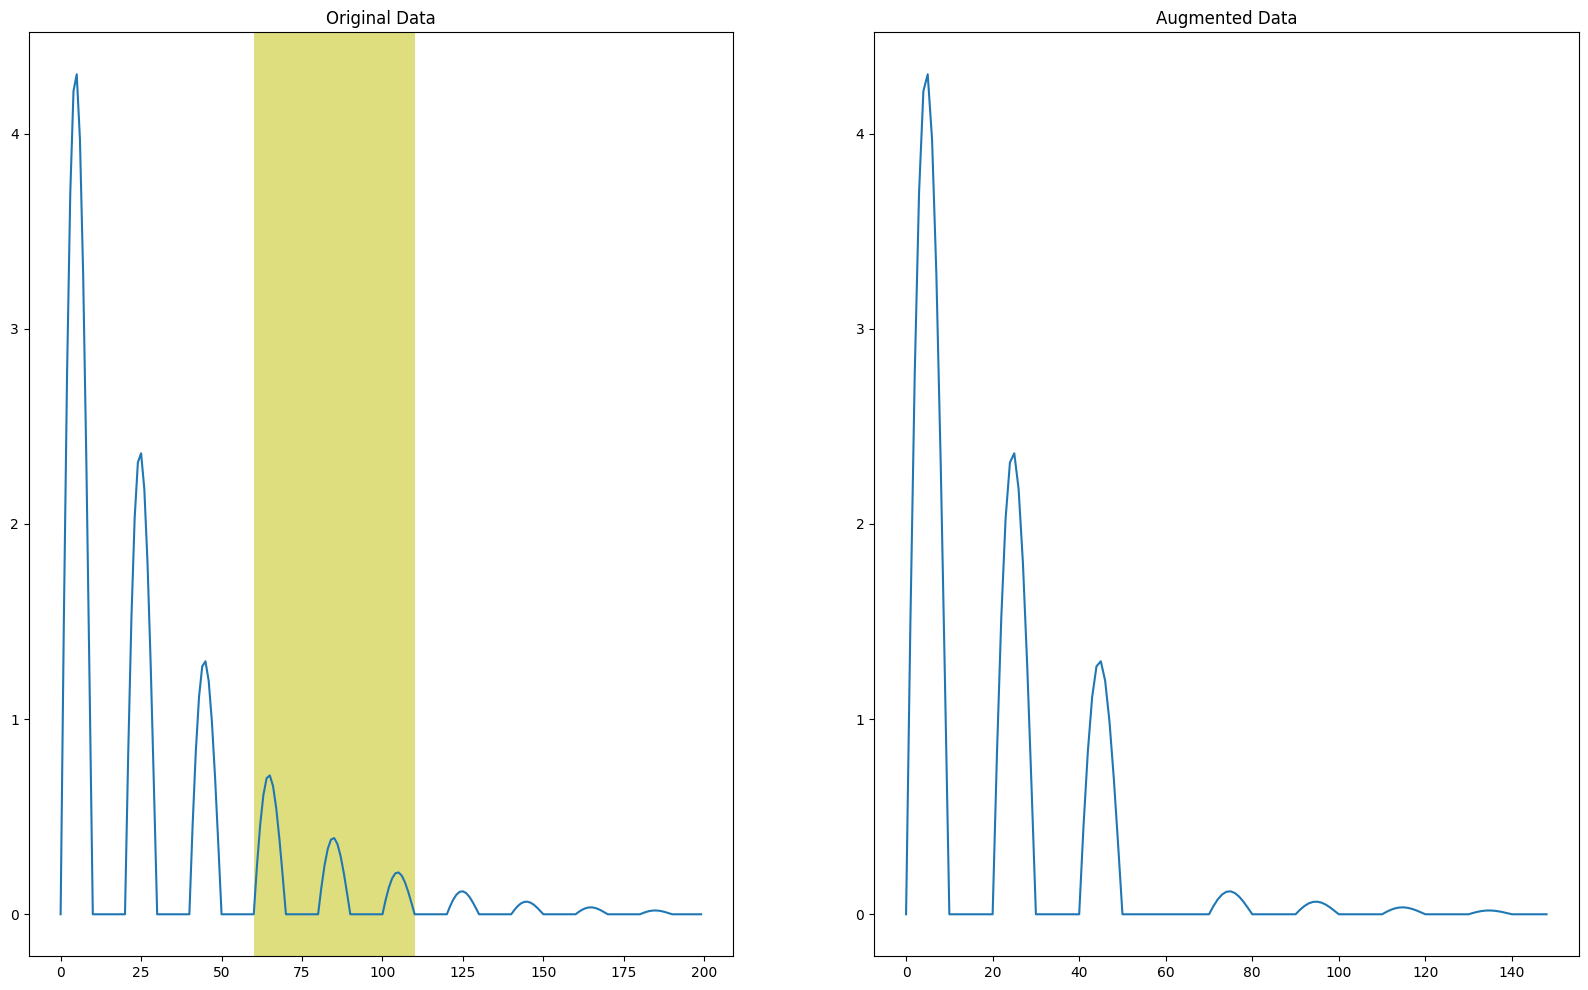

In [8]:
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(time_series_data[:])
plt.axvspan(60, 110, facecolor='y', alpha=0.5);

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(np.concatenate((time_series_data[0:60], time_series_data[110:-1])))

## 3. Scaling

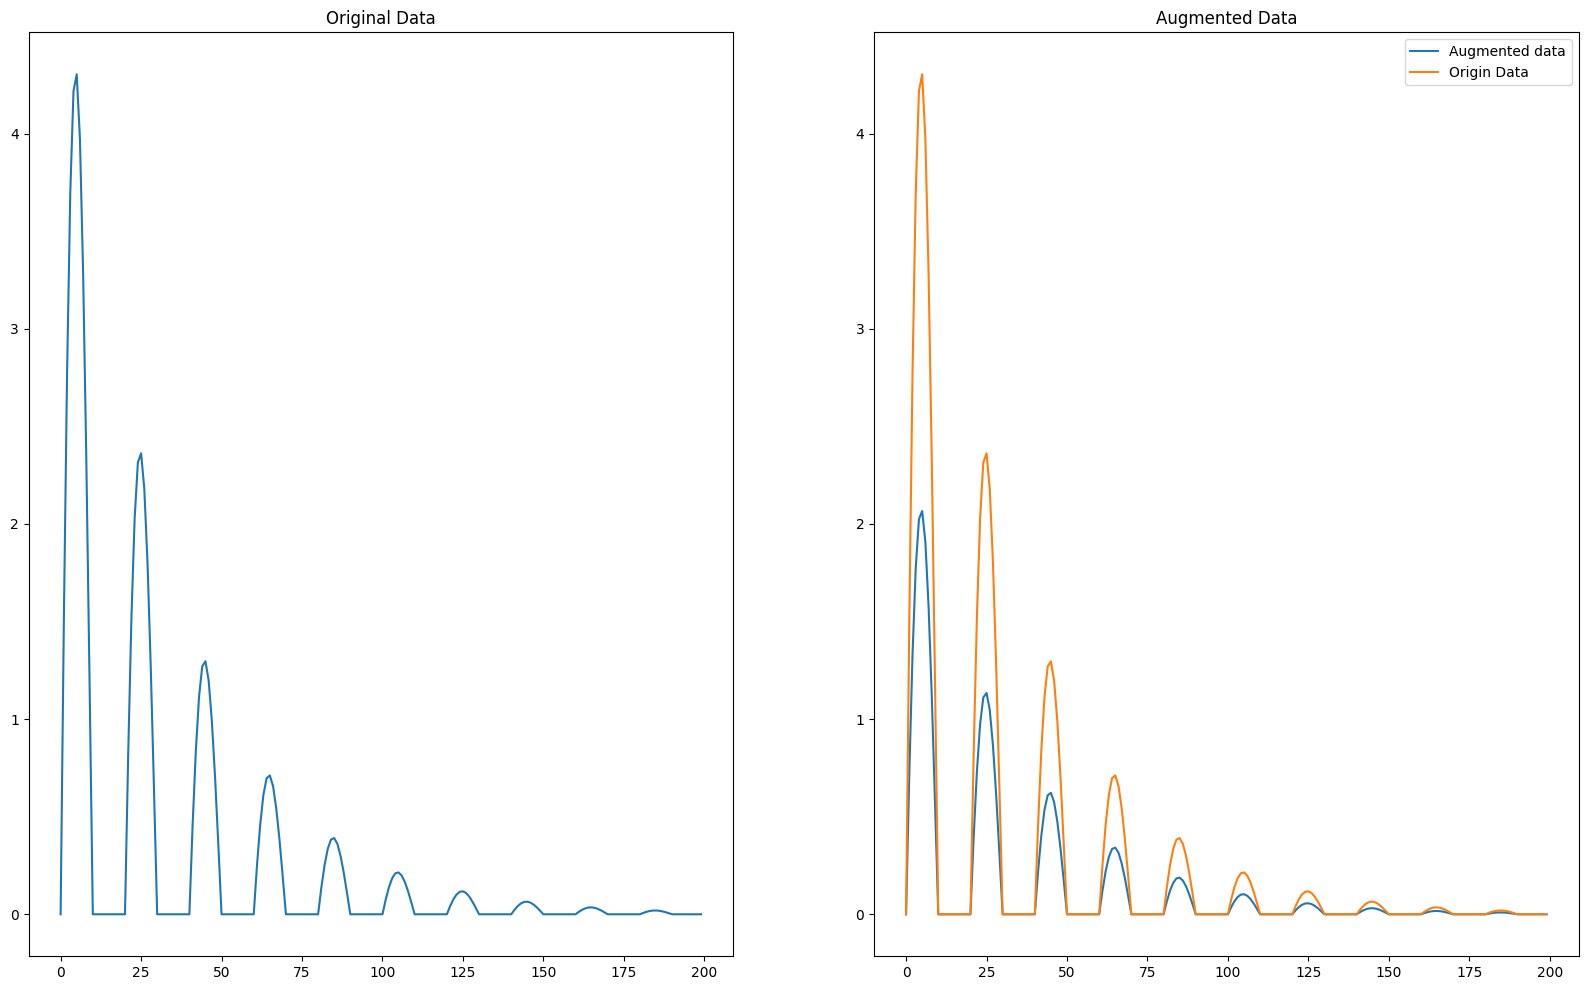

In [9]:
def add_scaling(time_series, scale_factor):
    """
    Scales a time series by multiplying each element by scale_factor.

    :param time_series: numpy array, time series to be scaled
    :param scale_factor: the number by which all elements of the series will be multiplied
    :return: numpy array, scaled time series
    """
    scaled_time_series = time_series * scale_factor
    return scaled_time_series

scale_factor = 0.48

augmented_time_series_data = add_scaling(time_series_data, scale_factor)
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(time_series_data[:])

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(augmented_time_series_data, label="Augmented data")
plt.plot(time_series_data[:], label="Origin Data")
plt.legend()

### 3.1. Magnitude Warping

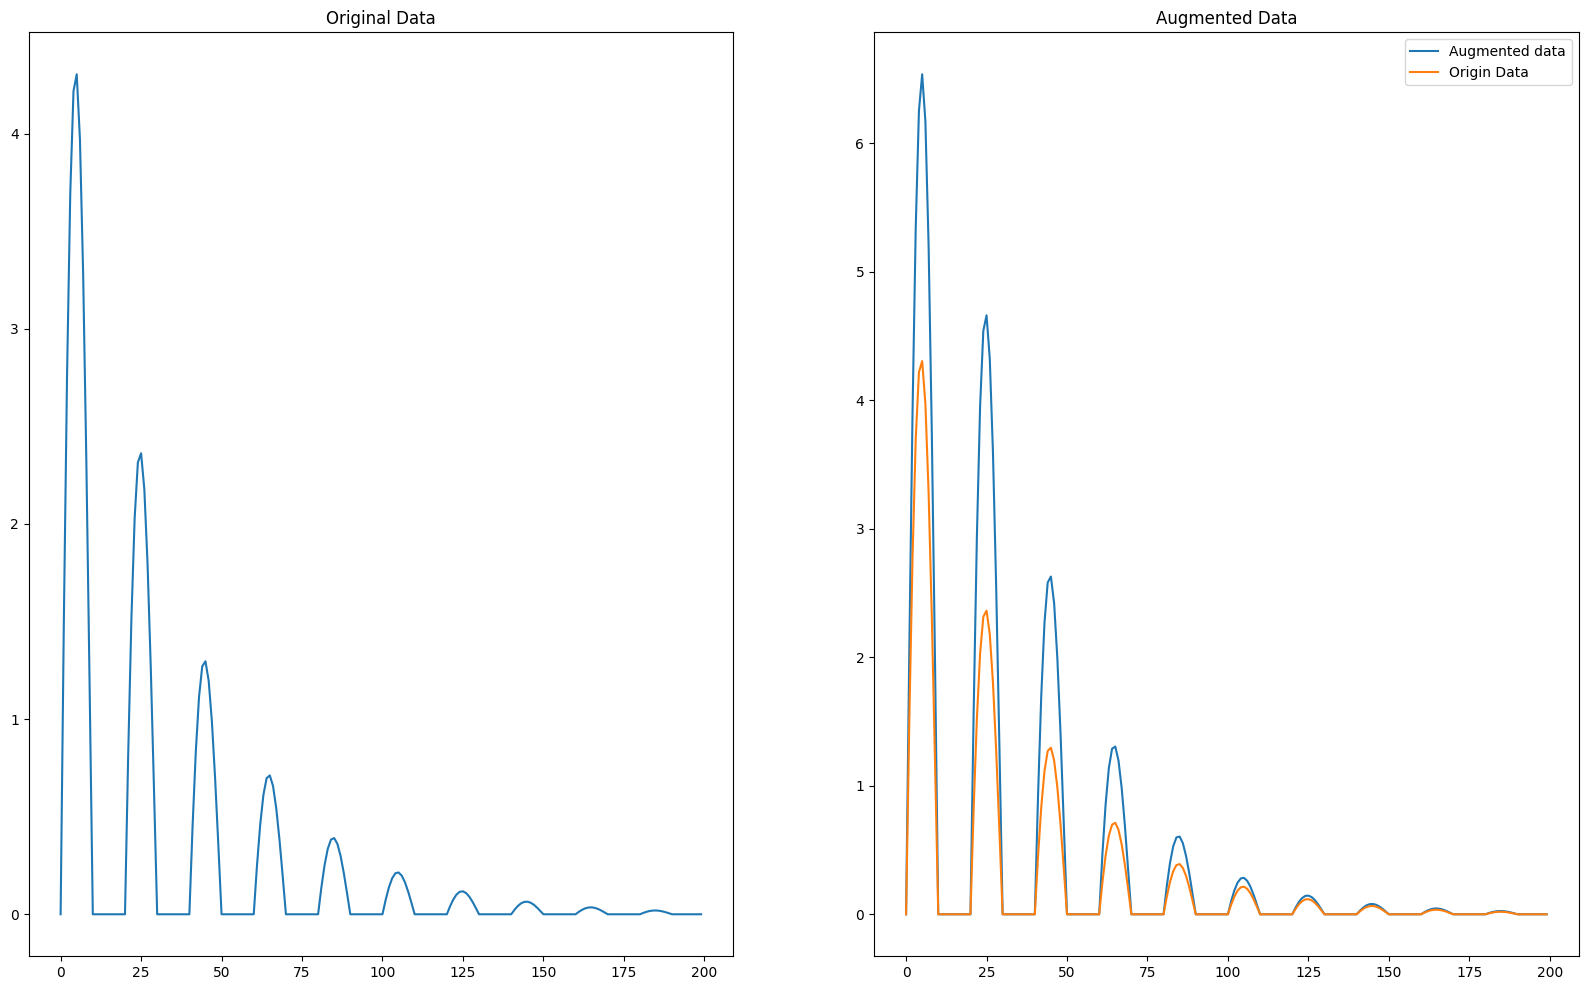

In [10]:
def magnitude_warping(time_series, num_knots=4, warp_std_dev=0.2):
    """
    Applies magnitude warping to a time series using cubic splines.

    :param time_series: np.array, time series to distort
    :param num_knots: int, number of control points for splines
    :param warp_std_dev: float, standard deviation for distorting the values of control points
    :return: np.array, distorted time series
    """
    # Generating random spline knots within a time series
    knot_positions = np.linspace(0, len(time_series) - 1, num=num_knots)
    knot_values = 1 + np.random.normal(0, warp_std_dev, num_knots)

    # Creating a Cubic Spline Function Through Knots
    spline = CubicSpline(knot_positions, knot_values)

    # Generating time indexes for a time series
    time_indexes = np.arange(len(time_series))

    # Applying distortion to a time series
    warped_time_series = time_series * spline(time_indexes)

    return warped_time_series


augmented_time_series_data = magnitude_warping(time_series_data, num_knots=5, warp_std_dev=0.45)
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(time_series_data[:])

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(augmented_time_series_data, label="Augmented data")
plt.plot(time_series_data[:], label="Origin Data")
plt.legend()

### 3.2. Time Warping

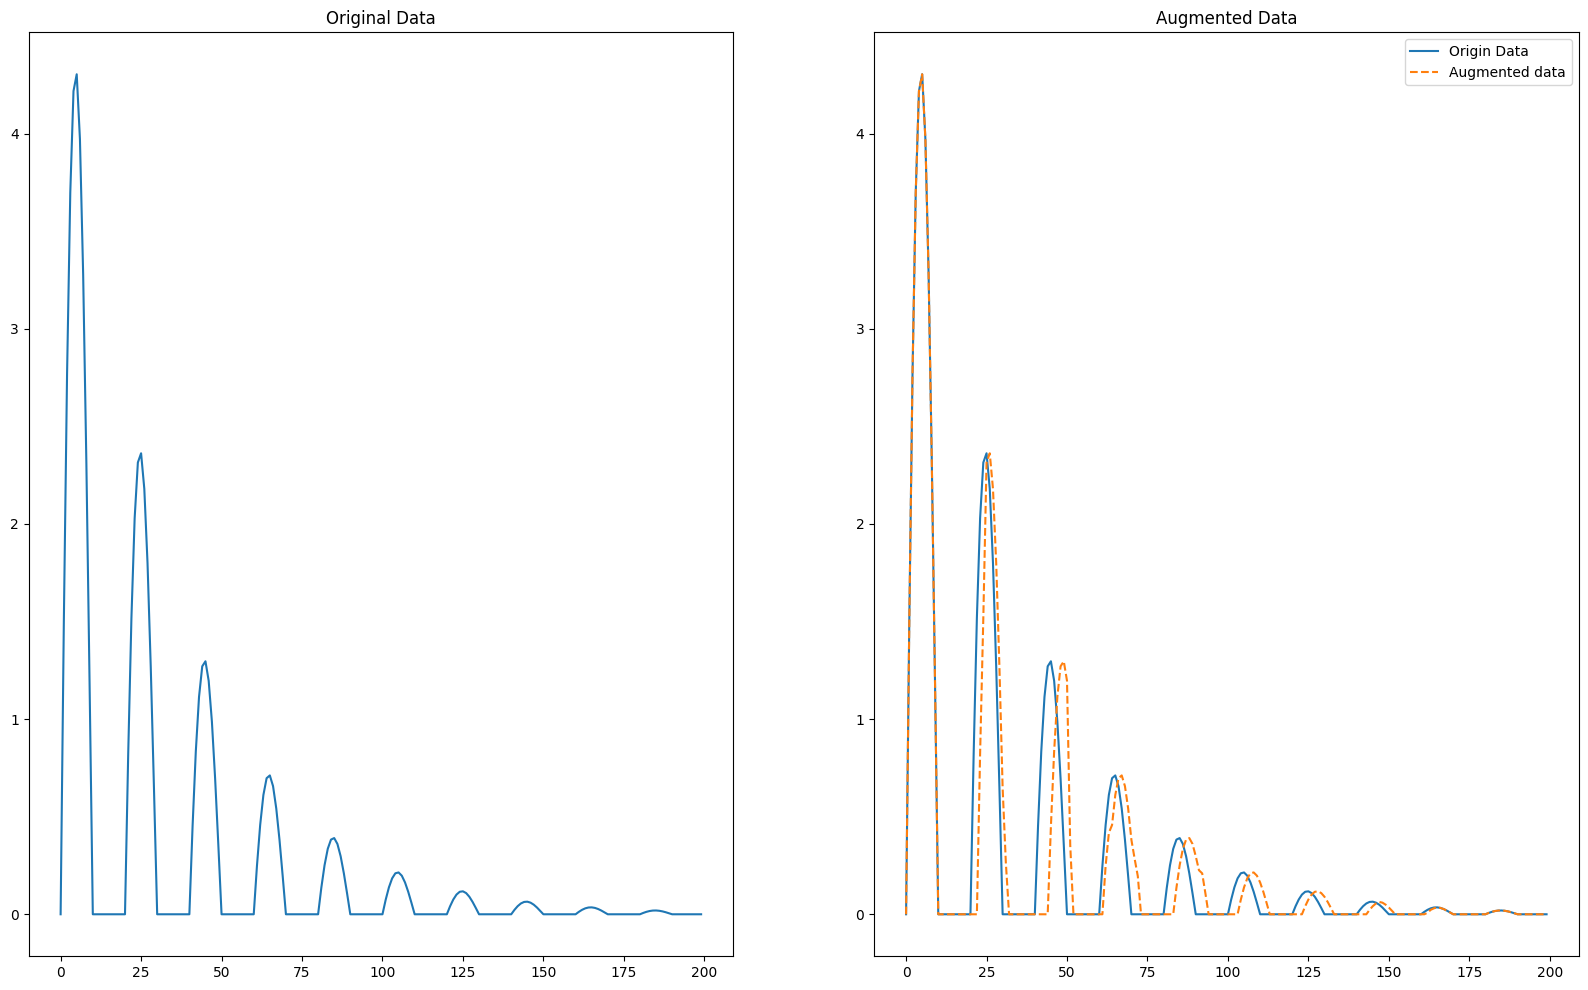

In [11]:
def time_warping(time_series, num_operations=10, warp_factor=0.2):
    """
    Applying time warping to a time series.

    :param time_series: Time series, numpy array.
    :param num_operations: Number of insert/delete operations.
    :param warp_factor: Warp factor that determines the impact of operations.
    :return: Distorted time series.
    """
    warped_series = time_series.copy()
    for _ in range(num_operations):
        operation_type = random.choice(["insert", "delete"])
        index = random.randint(1, len(warped_series) - 2)
        if operation_type == "insert":
            # Insert a value by interpolating between two adjacent points
            insertion_value = (warped_series[index - 1] + warped_series[index]) * 0.5
            warp_amount = insertion_value * warp_factor * random.uniform(-1, 1)
            warped_series = np.insert(warped_series, index, insertion_value + warp_amount)
        elif operation_type == "delete":
            # Remove a random point
            warped_series = np.delete(warped_series, index)
        else:
            raise ValueError("Invalid operation type")

    return warped_series

augmented_time_series_data = time_warping(time_series_data, num_operations=20, warp_factor=0.25)
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(time_series_data[:])

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(time_series_data[:], label="Origin Data")
plt.plot(augmented_time_series_data, label="Augmented data", linestyle="--")
plt.legend()

## 4. Permutation

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_7740\677557842.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


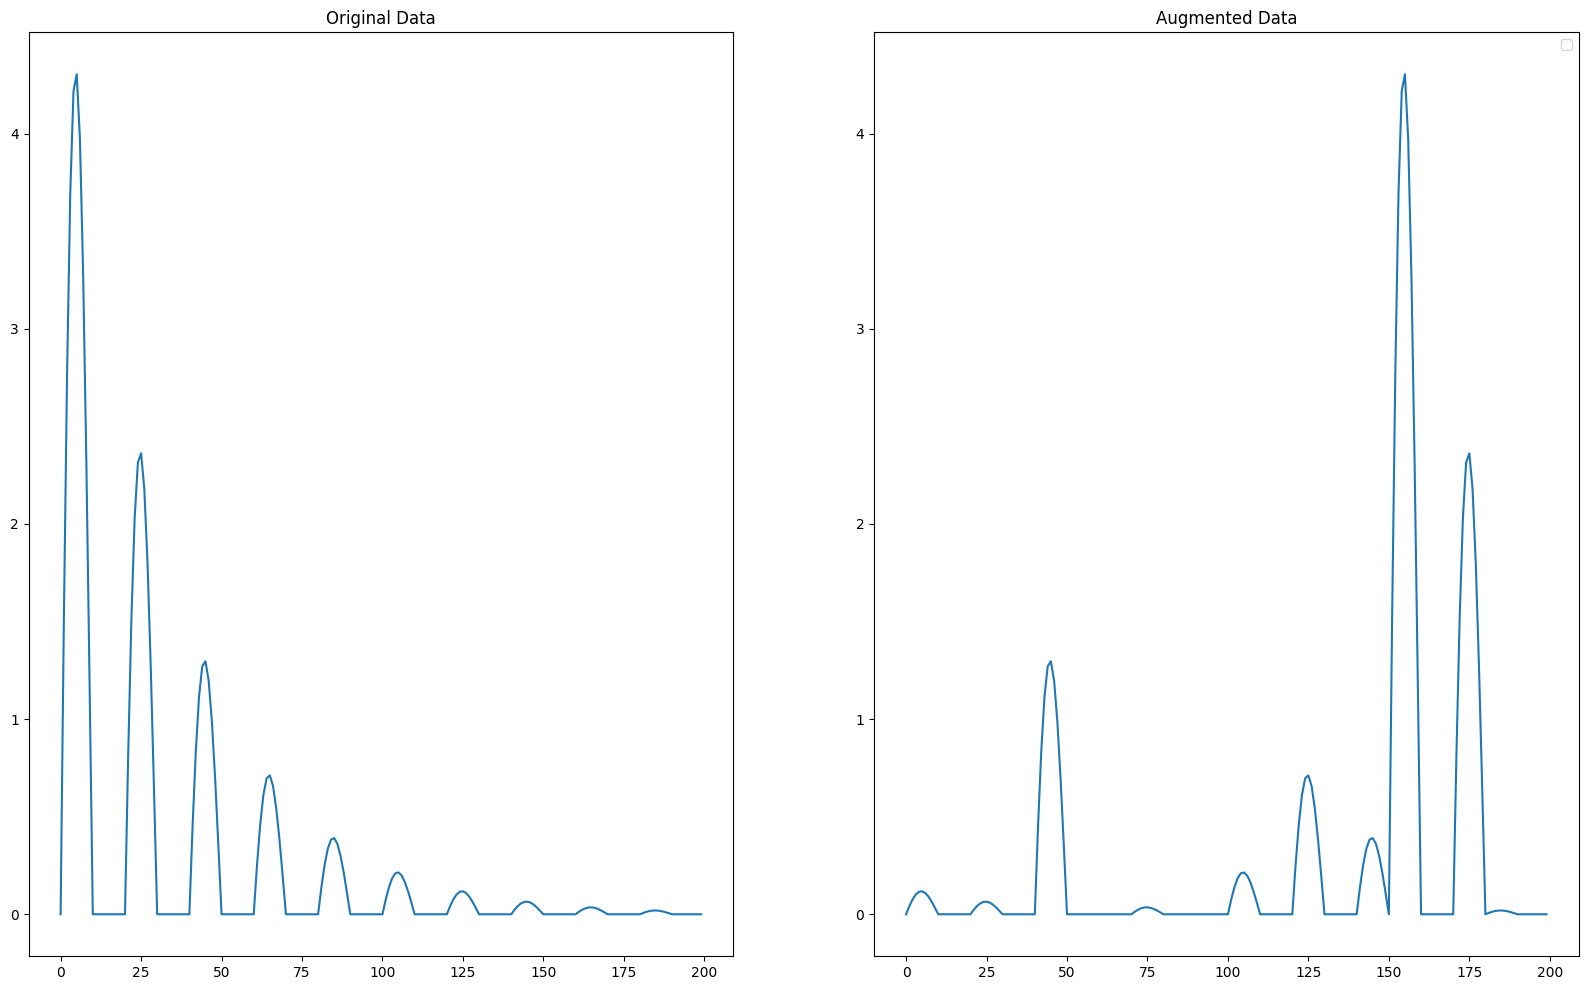

In [12]:
def shuffle_time_slices(time_series, slice_size=1):
    """
    Shuffle different time slices of the provided array.

    Parameters:
    time_series (array-like): An array containing time-series data.
    slice_size (int): The size of each time slice that will be shuffled.

    Returns:
    shuffled_data (array-like): The array with shuffled time slices.
    """

    # Convert to numpy array if not already
    time_series = np.array(time_series)

    if slice_size <= 0 or slice_size > len(time_series):
        raise ValueError("Slice size must be within the range 1 to len(data)")

    num_slices = len(time_series) // slice_size

    # Cut the data into slices
    slices = [time_series[i * slice_size:(i + 1) * slice_size] for i in range(num_slices)]

    # Shuffle the slices
    np.random.shuffle(slices)

    # Concatenate the shuffled slices
    shuffled_data = np.concatenate(slices)

    # Include any leftover data that couldn't form a complete slice
    remainder = len(time_series) % slice_size
    if remainder > 0:
        remainder_data = time_series[-remainder:]
        shuffled_data = np.concatenate([shuffled_data, remainder_data])

    return shuffled_data

augmented_time_series_data = shuffle_time_slices(time_series_data, slice_size=30)
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(time_series_data[:])

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(augmented_time_series_data)
plt.legend()

## 5. Rotation

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_7740\3435940254.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


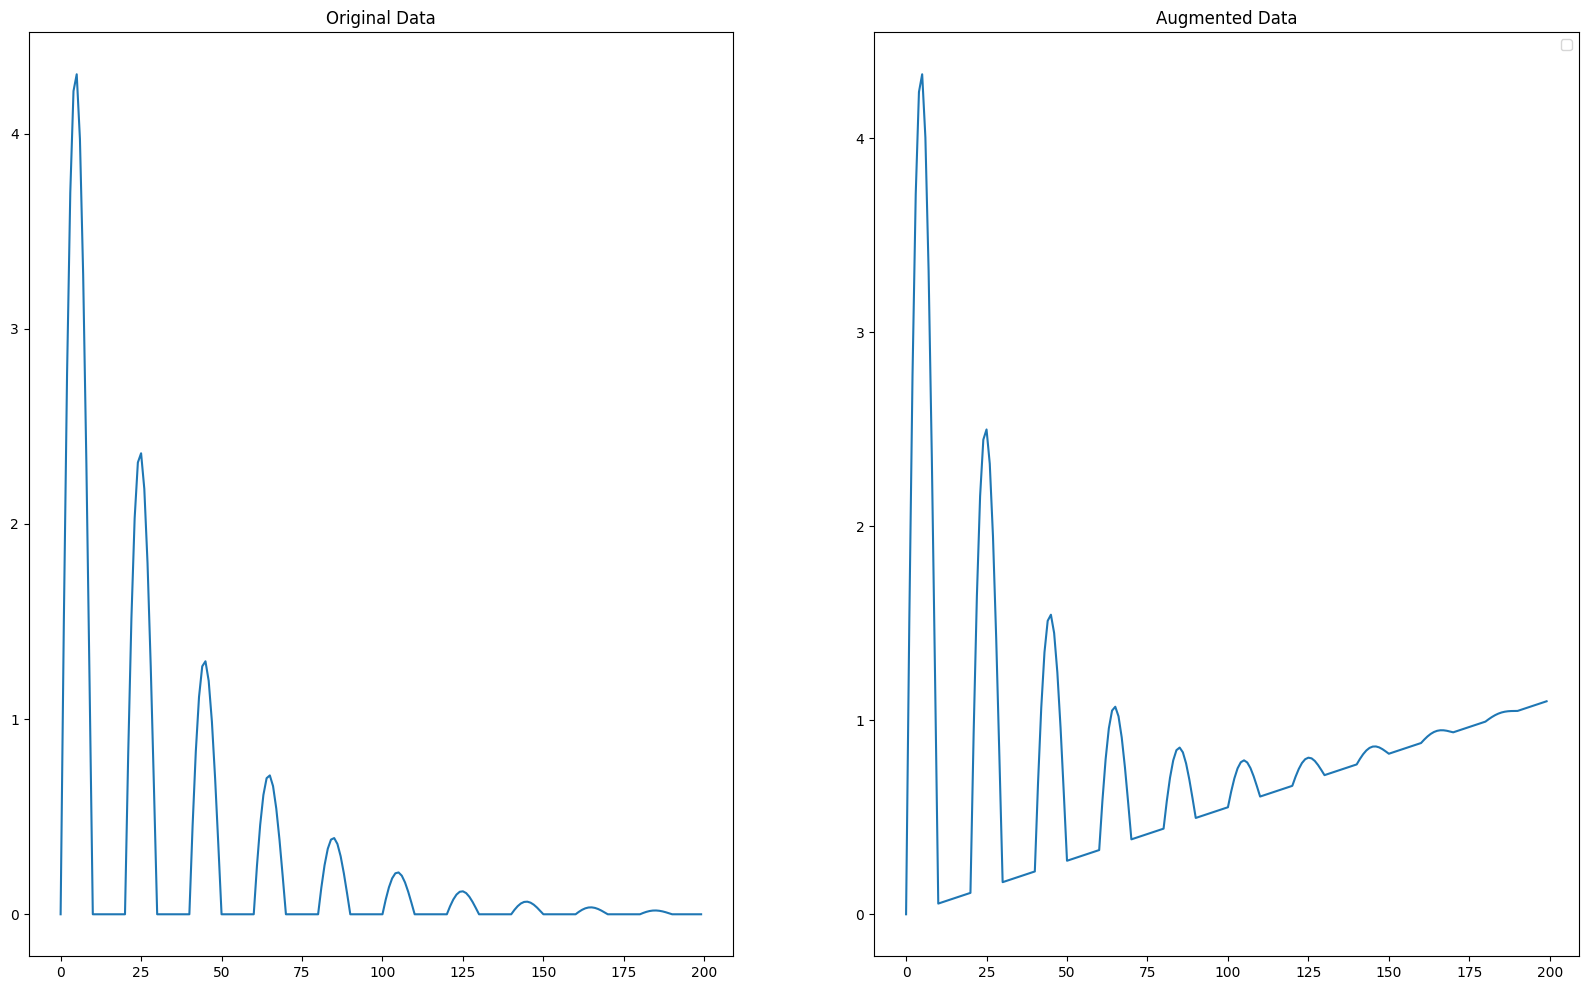

In [21]:
def rotation(time_series, sigma=1.0):
    """
    Rotates a time series using an angle selected from normal distribution with standard deviation sigma.

    :param time_series: list or np.array, time series for augmentation
    :param sigma: float, standard deviation of the rotation angle in degrees
    :return: np.array, rotated time series
    """
    # Generating the rotation angle from the normal distribution
    angle = np.random.normal(scale=sigma)
    # Convert angle to radians
    angle_rad = np.deg2rad(angle)

    # Creating a rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    # Let's transform the time series into a two-dimensional array, where each point is a pair (time, value)
    time_indices = np.arange(len(time_series)).reshape(-1, 1)
    values = np.array(time_series).reshape(-1, 1)
    two_dim_points = np.hstack((time_indices, values))

    # Apply the rotation matrix to each point in the time series
    rotated_points = two_dim_points.dot(rotation_matrix)

    # Returning only time series values after rotation
    return rotated_points[:, 1]

augmented_time_series_data = rotation(time_series_data)
plt.figure(figsize=(20, 12))

plt.subplot(1,2,1)
plt.title("Original Data")
plt.plot(time_series_data[:])

plt.subplot(1,2,2)
plt.title("Augmented Data")
plt.plot(augmented_time_series_data)
plt.legend()